<a href="https://colab.research.google.com/github/Sanstheskelato/mes-codes-IA/blob/main/IA_chien_chat_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

In [45]:
def load_data(data_dir):
    images = []
    labels = []
    for label, category in enumerate(['chat', 'chien']):
        folder = os.path.join(data_dir, category)
        for filename in os.listdir(folder):
            image_path = os.path.join(folder, filename)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Spécifiez le répertoire des données
data_dir = '/content/dataset_chien_chat'  # Remplacez par le chemin de votre dossier de données

# Charger les données
images, labels = load_data(data_dir)

# Diviser les données en ensembles d'entraînement et de validation
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normaliser les images
train_images = train_images / 255.0
val_images = val_images / 255.0

In [46]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen = datagen.flow(train_images, train_labels, batch_size=32)

In [47]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Ne pas entraîner les couches de base

In [48]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [50]:
history = model.fit(
    train_datagen,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
43/43 [==============================] - 86s 2s/step - loss: 0.5794 - accuracy: 0.7168 - val_loss: 0.2911 - val_accuracy: 0.9379 - lr: 1.0000e-04
Epoch 2/10
43/43 [==============================] - 94s 2s/step - loss: 0.3304 - accuracy: 0.8769 - val_loss: 0.1958 - val_accuracy: 0.9527 - lr: 1.0000e-04
Epoch 3/10
43/43 [==============================] - 87s 2s/step - loss: 0.2648 - accuracy: 0.9051 - val_loss: 0.1562 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 4/10
43/43 [==============================] - 78s 2s/step - loss: 0.2351 - accuracy: 0.9118 - val_loss: 0.1412 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 5/10
43/43 [==============================] - 85s 2s/step - loss: 0.2168 - accuracy: 0.9133 - val_loss: 0.1267 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 6/10
43/43 [==============================] - 87s 2s/step - loss: 0.1991 - accuracy: 0.9192 - val_loss: 0.1265 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 7/10
43/43 [==============================] - 84s 2s

11/11 [==============================] - 14s 1s/step


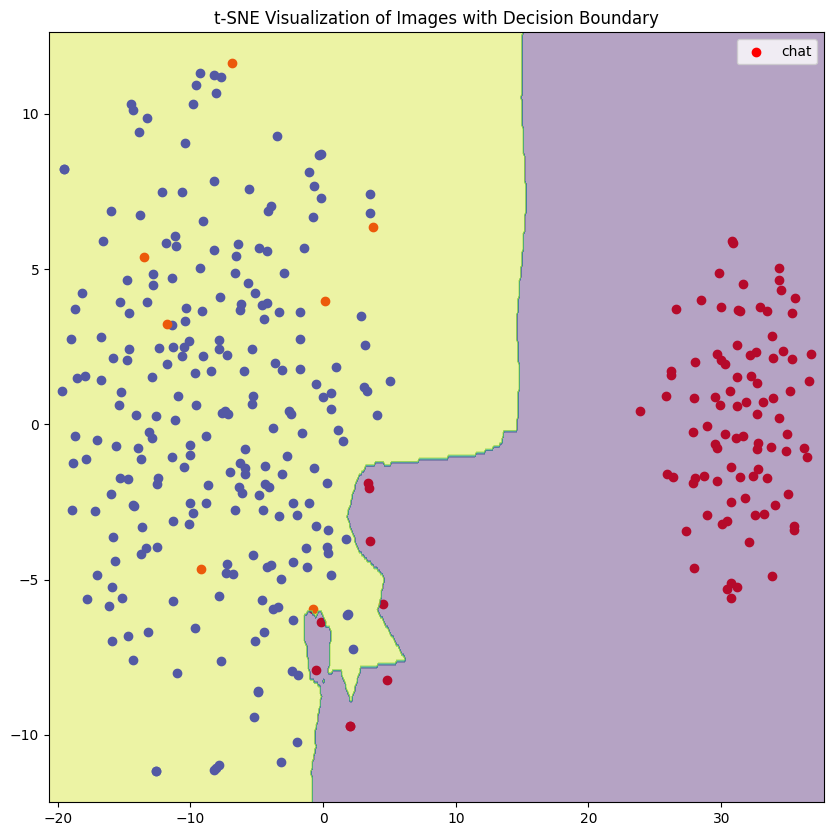

In [51]:
# Extraire les caractéristiques du modèle avant la dernière couche
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_extractor.predict(val_images)

# Normaliser les caractéristiques
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Appliquer t-SNE sur les caractéristiques normalisées
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Entraîner un classificateur k-NN sur les caractéristiques réduites
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(features_2d, val_labels)

# Tracer les points
plt.figure(figsize=(10, 10))
for i, label in enumerate(val_labels):
    if label == 0:
        plt.scatter(features_2d[i, 0], features_2d[i, 1], c='r', label='chat' if i == 0 else "")
    else:
        plt.scatter(features_2d[i, 0], features_2d[i, 1], c='b', label='chien' if i == 0 else "")

# Créer une grille de points pour tracer la frontière de décision
x_min, x_max = features_2d[:, 0].min() - 1, features_2d[:, 0].max() + 1
y_min, y_max = features_2d[:, 1].min() - 1, features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Utiliser le classificateur k-NN pour prédire sur la grille de points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière de décision
plt.contourf(xx, yy, Z, alpha=0.4)

plt.legend()
plt.title('t-SNE Visualization of Images with Decision Boundary')
plt.show()

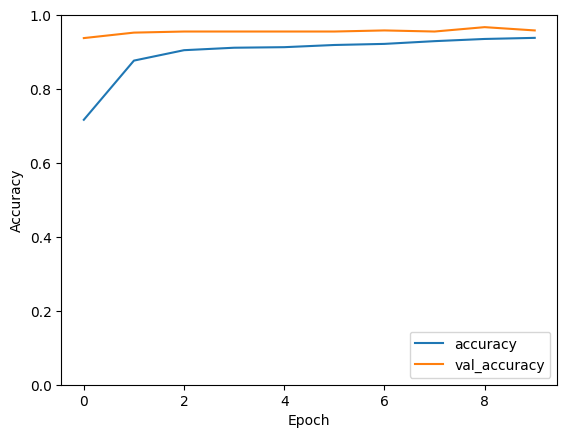

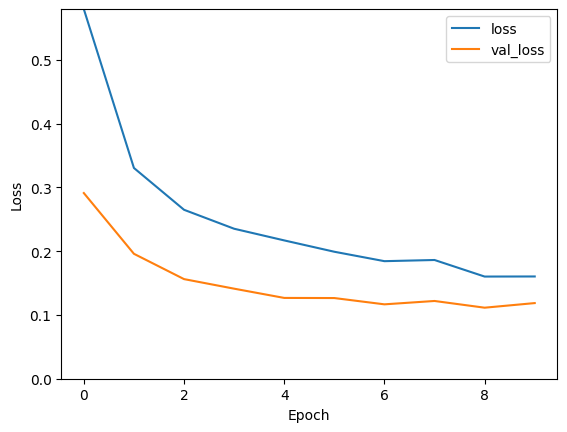

In [52]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.show()

In [78]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("L'image n'a pas pu être chargée. Vérifiez le chemin de l'image.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    return image

def predict_image(image_path):
    processed_image = load_and_preprocess_image(image_path)
    prediction = model.predict(processed_image)

    if prediction[0] > 0.5:
        print("C'est un chien avec une probabilité de {:.2f}".format(prediction[0][0]))
    else:
        print("C'est un chat avec une probabilité de {:.2f}".format(1 - prediction[0][0]))

# Exemple d'utilisation
image_path = '/content/pred_chat/1718633111716.jpeg'
predict_image(image_path)

1/1 [==============================] - 0s 46ms/step
C'est un chat avec une probabilité de 1.00
